In [105]:
from pathlib import Path as pt
import umap
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from typing import List
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from typing import Dict, Tuple

from rdkit import Chem
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')
tqdm.pandas()

In [96]:
from load_data import embedded_vectors_dir, names, titles, plots_dir, property_units, property_names
names, plots_dir

(['tmpC_topelements',
  'tbp_topelements',
  'vp_kPa_25C_topelements',
  'Pc_MPa',
  'Tc_K'],
 PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML-properties/plots'))

In [84]:
class ChemicalClusterAnalyzer:
    """Analyzes chemical structure clusters and their functional groups."""

    def __init__(self):
        # Define common functional groups and their SMARTS patterns
        self.functional_groups = {
            "Alcohol": "[OH]",
            "Carboxylic Acid": "[CX3](=O)[OX2H1]",
            "Ester": "[#6][CX3](=O)[OX2H0][#6]",
            "Ether": "[OD2]([#6])[#6]",
            "Aldehyde": "[CX3H1](=O)[#6]",
            "Ketone": "[#6][CX3](=O)[#6]",
            "Amine": "[NX3;H2,H1;!$(NC=O)]",
            "Amide": "[NX3][CX3](=[OX1])[#6]",
            "Aromatic": "a1aaaaa1",
            "Alkene": "[CX3]=[CX3]",
            "Alkyne": "[CX2]#[CX2]",
            "Nitrile": "[NX1]#[CX2]",
            "Nitro": "[NX3](=O)=O",
            "Sulfonic Acid": "[SX4](=[OX1])(=[OX1])[OX2H]",
            "Phosphate": "[PX4](=[OX1])([OX2H])([OX2H])[OX2H]",
            "Halogen": "[F,Cl,Br,I]",
        }

    def identify_functional_groups(self, smiles: str) -> Dict[str, int]:
        """
        Identifies functional groups in a molecule.

        Args:
            smiles: SMILES string of the molecule

        Returns:
            Dictionary of functional group counts
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {}

            groups = {}
            for name, smarts in self.functional_groups.items():
                pattern = Chem.MolFromSmarts(smarts)
                if pattern is not None:
                    matches = mol.GetSubstructMatches(pattern)
                    if matches:
                        groups[name] = len(matches)
            return groups
        except Exception:
            return {}

    def analyze_cluster_chemistry(
        self,
        reduced_embeddings: np.ndarray,
        smiles_list: List[str],
        eps: float = 0.5,
        min_samples: int = 5,
    ) -> Tuple[np.ndarray, Dict]:
        """
        Performs clustering and analyzes chemical features of each cluster.

        Args:
            reduced_embeddings: UMAP-reduced embeddings
            smiles_list: List of SMILES strings
            eps: DBSCAN epsilon parameter
            min_samples: DBSCAN minimum samples parameter

        Returns:
            Cluster labels and cluster analysis results
        """
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(reduced_embeddings)
        labels = clustering.labels_

        # Analyze each cluster
        cluster_analysis = {}
        for cluster_id in tqdm(set(labels)):
            if cluster_id == -1:  # Skip noise points
                continue

            # Get SMILES strings for this cluster
            cluster_mask = labels == cluster_id
            cluster_smiles = np.array(smiles_list)[cluster_mask]

            # Analyze functional groups
            all_groups = []
            for smiles in cluster_smiles:
                groups = self.identify_functional_groups(smiles)
                all_groups.extend(groups.keys())

            # Calculate group frequencies
            group_freq = Counter(all_groups)
            total_mols = len(cluster_smiles)
            group_freq = {k: v / total_mols for k, v in group_freq.items()}

            # Store analysis results
            cluster_analysis[cluster_id] = {
                "size": sum(cluster_mask),
                "functional_groups": group_freq,
                "center": reduced_embeddings[cluster_mask].mean(axis=0),
            }

        return labels, cluster_analysis



In [109]:
def get_umap_df(
    ind: int,
    n_neighbors = 15,
    min_dist = 0.1,
    random_state = 42,
    dbscan_eps = 0.7,
    dbscan_min_samples = 15,
    perplexity = 3,
    mode: str = 'umap'
):
    
    n_components = 2
    
    df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'processed_df.parquet')
    label_issues_df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'label_issues_xgboost.parquet')
    cleaned_df = df[~label_issues_df["is_label_issue"]]
    print(f'Original data: {df.shape}, Cleaned data: {cleaned_df.shape}')

    smiles_list = cleaned_df['SMILES'].to_list()
    print(f'SMILES list: {len(smiles_list)}')

    X = cleaned_df.iloc[:, 2:].to_numpy()
    y = cleaned_df["y"].to_numpy()
    print(f'X: {X.shape}, y: {y.shape}')

    # Scale embeddings
    print("Scaling embeddings...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform UMAP
    if mode == 'umap':
        print("Performing UMAP...")
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=n_components,
            n_jobs=-1,
            random_state=random_state
        )

        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'UMAP done: {reduced_embeddings.shape}')
    elif mode == 'tsne':    
        reducer = TSNE(n_components=n_components, learning_rate='auto', init='random', perplexity=perplexity)
        reduced_embeddings = reducer.fit_transform(X_scaled)
        print(f'TSNE done: {reduced_embeddings.shape}')

    print("Analyzing clusters...")
    analyzer = ChemicalClusterAnalyzer()
    labels, _ = analyzer.analyze_cluster_chemistry(
        reduced_embeddings,
        smiles_list,
        eps=dbscan_eps,
        min_samples=dbscan_min_samples,
    )
    print(f'Labels: {len(labels)}')

    umap_df = pd.DataFrame(
        {
            "INDEX": cleaned_df.index,
            "UMAP1": reduced_embeddings[:, 0],
            "UMAP2": reduced_embeddings[:, 1],
            "Cluster": labels,
            "SMILES": smiles_list,
            "y": y,
        }
    )
    
    return umap_df


In [67]:
def annotate_fig(umap_df: pd.DataFrame, ax: plt.Axes):
    # Define distinct colors for clusters
    # cluster_colors = plt.cm.tab20(np.linspace(0, 1, len(umap_df['Cluster'].unique())))
    
    # Add cluster circles and labels
    for idx, cluster_id in enumerate(sorted(umap_df['Cluster'].unique())):
        if cluster_id == -1:  # Skip noise points
            continue
            
        # Get points for this cluster
        cluster_points = umap_df[umap_df['Cluster'] == cluster_id]
        
        # Calculate cluster center
        center_x = cluster_points['UMAP1'].mean()
        center_y = cluster_points['UMAP2'].mean()
        
        # Calculate cluster radius
        std_x = cluster_points['UMAP2'].std() * 2
        std_y = cluster_points['UMAP2'].std() * 2
        radius = max(std_x, std_y)
        
        # Get color for this cluster
        # cluster_color = cluster_colors[idx]
        cluster_color = 'black'
        # Draw circle around cluster
        circle = plt.Circle(
            (center_x, center_y),
            radius,
            fill=False,
            linestyle='-',
            color=cluster_color,
            alpha=0.5,
            # linewidth=2
        )
        ax.add_patch(circle)
        
        # Add just the cluster ID at the circle's boundary
        # Calculate position on the circle's circumference (top of circle)
        label_x = center_x
        label_y = center_y + radius
        
        # Add cluster label with white background for better visibility
        ax.text(label_x, label_y, str(cluster_id),
                horizontalalignment='center',
                verticalalignment='bottom',
                color=cluster_color,
                fontweight='bold',
                fontsize=12,
                # bbox=dict(facecolor='white', 
                #          edgecolor=cluster_color,
                #          alpha=0.9,
                #          pad=0.5,
                #          boxstyle='round')
                )
    return ax

def static_fig(umap_df: pd.DataFrame, title_name: str, short_title_name: str):
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

    # Create the scatter plot using seaborn
    scatter = sns.scatterplot(
        data=umap_df,
        x="UMAP1",
        y="UMAP2",
        hue="y",
        palette="viridis",
        ax=ax,
        s=50,
        alpha=0.6,
    )

    # Remove the automatic legend
    scatter.legend_.remove()

    # Create and customize the colorbar
    norm = plt.Normalize(umap_df["y"].min(), umap_df["y"].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    colorbar = fig.colorbar(sm, ax=ax)
    colorbar.set_label(title_name, fontsize=12)

    ax.set_xlabel("UMAP1", fontsize=12)
    ax.set_ylabel("UMAP2", fontsize=12)
    ax.set_title(short_title_name, fontsize=16)
    
    plt.tight_layout()
    # plt.show()
    return fig, ax

Original data: (398, 302), Cleaned data: (353, 302)
SMILES list: 353
X: (353, 300), y: (353,)
Scaling embeddings...
Performing UMAP...
UMAP done: (353, 2)
Analyzing clusters...


100%|██████████| 5/5 [00:00<00:00, 92.36it/s]

Labels: 353


<Figure size 640x480 with 0 Axes>

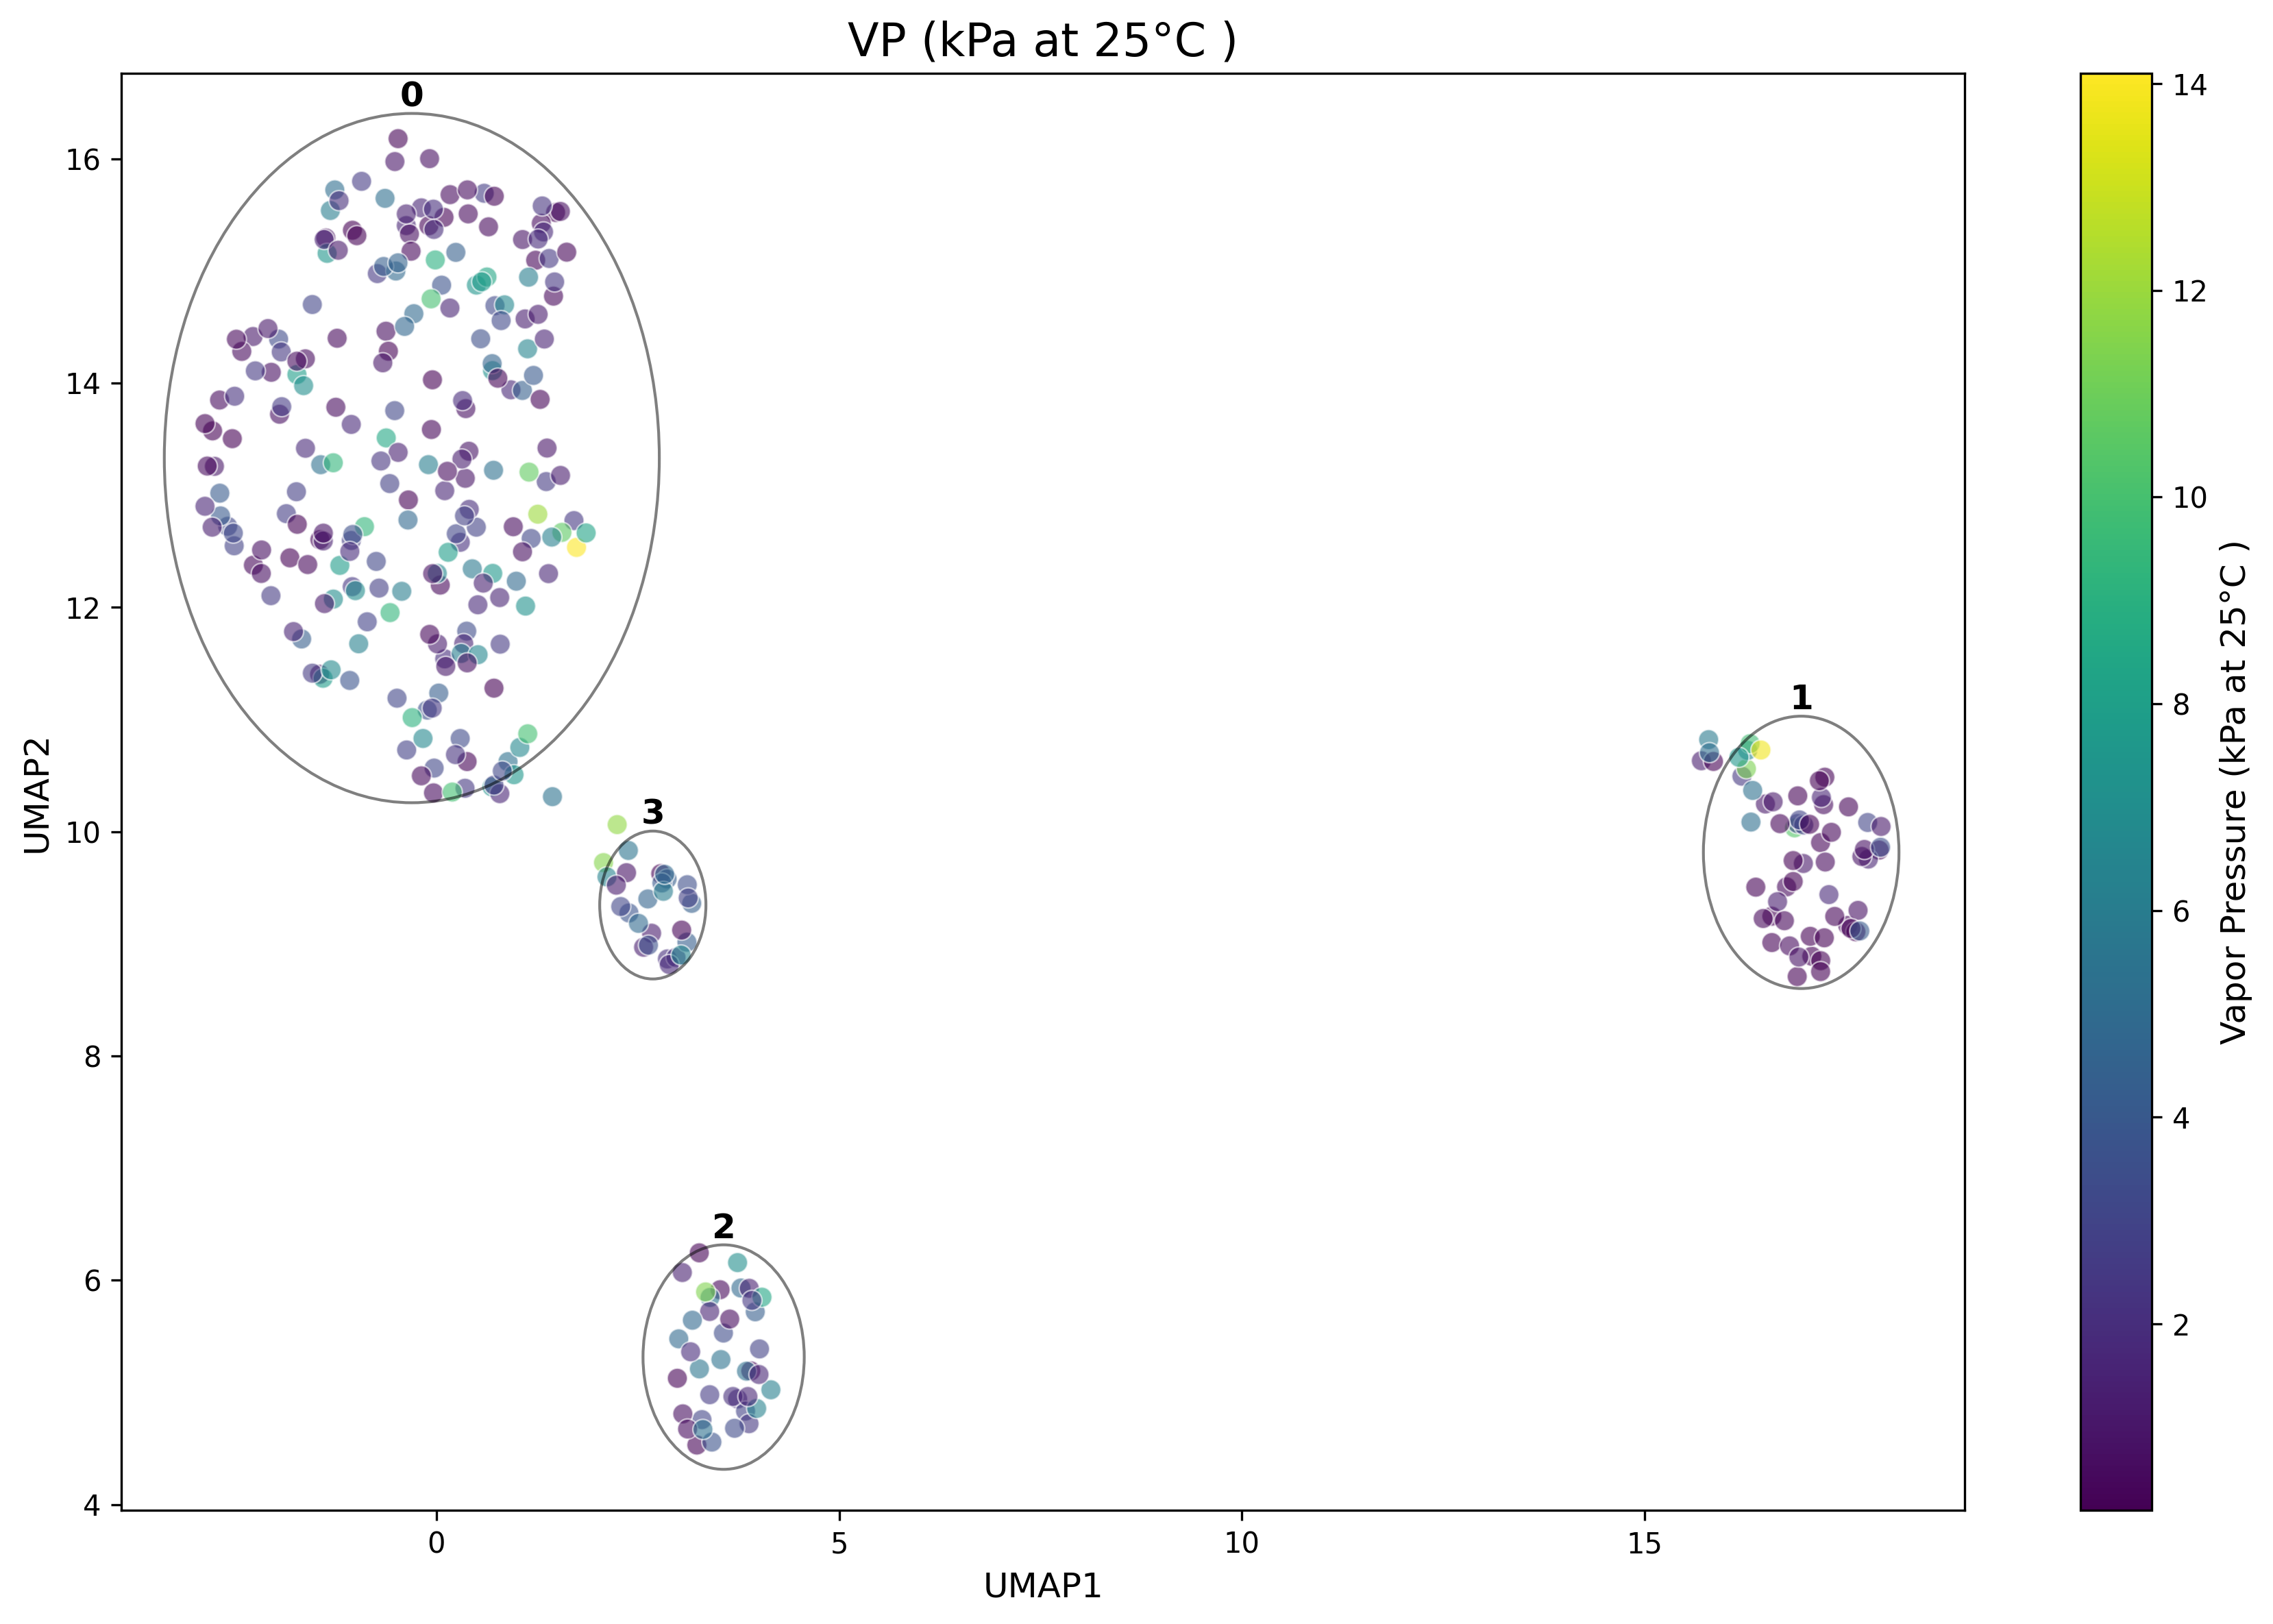

In [115]:
ind = 2
# print(titles[ind])
n_neighbors = 25
min_dist = 0.3
random_state = 42
dbscan_eps = 0.5
dbscan_min_samples = 5
perplexity = 60
mode = 'umap'
# mode = 'tsne'

umap_df = get_umap_df(
    ind, 
    n_neighbors, 
    min_dist, 
    random_state, 
    dbscan_eps, 
    dbscan_min_samples, 
    perplexity, 
    mode=mode
)

# umap_df = pd.read_parquet(
#     embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
# )

title_name = f'{property_names[ind]} ({property_units[ind]})'
short_title_name = f'{titles[ind]} ({property_units[ind]})'
fig, ax = static_fig(umap_df, title_name, short_title_name)
ax = annotate_fig(umap_df, ax)
# fig.savefig(plots_dir / f'{names[ind]}_umap.png')
plt.show()

In [69]:
for ind in range(0, len(embedded_vectors_dir)):
    umap_df = pd.read_parquet(
        embedded_vectors_dir[ind] / f'processed_mol2vec_embeddings/umap/cleaned_label_issues_xgboost/[umap_df]_{names[ind]}_scaled_random_state_42_umap_25_0.3_2_cluster_eps_0.7_min_samples_15.parquet'
    )
    # print(umap_df['Cluster'].unique(), umap_df['Cluster'].value_counts())
    # display(umap_df)

    title_name = f'{property_names[ind]} ({property_units[ind]})'
    short_title_name = f'{titles[ind]} ({property_units[ind]})'
    fig, ax = static_fig(umap_df, title_name, short_title_name)
    ax = annotate_fig(umap_df, ax)
    fig.savefig(plots_dir / f'{names[ind]}_umap.png')
    # plt.show()
    plt.close(fig)
    print(f'{names[ind]} done')

tmpC_topelements done
tbp_topelements done
vp_kPa_25C_topelements done
Pc_MPa done
Tc_K done


<Figure size 640x480 with 0 Axes>

In [81]:
ind = 0
df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'processed_df.parquet')
label_issues_df = pd.read_parquet(embedded_vectors_dir[ind] / 'processed_mol2vec_embeddings' / 'label_issues_xgboost.parquet')
cleaned_df = df[~label_issues_df["is_label_issue"]]
display(df, label_issues_df, cleaned_df)

,SMILES,y,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
INDEX,,,,,,,,,,,,,,,,,,,,,
0,COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1,31.6,14.583024,7.004414,10.764027,9.659239,-7.881231,-12.125900,4.289826,11.829774,...,-2.557744,2.143950,-1.143839,7.093911,8.230412,2.932323,-9.742094,-3.931319,4.814355,0.262482
1,CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1,173.5,8.672269,3.382508,-1.009339,8.613342,-5.257068,-3.722235,-2.904521,3.233326,...,-3.215222,1.214921,0.065320,2.262887,3.039335,1.418446,-5.120859,0.569136,6.675544,-3.676702
2,CC(C=CC1(O)C(C)=CC(=O)CC1(C)C)=CC(=O)O,160.0,6.926352,4.612771,-0.524525,6.452645,-5.662361,-8.545525,-2.476228,6.148377,...,-2.327952,-0.310817,-2.341082,1.690612,1.047211,-0.751602,-5.519598,1.978377,6.315439,-2.911364
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1,263.0,9.478333,8.671986,2.309459,5.326269,-4.638491,-9.584875,-1.285632,10.793772,...,-4.620464,-0.298921,-1.304448,6.174148,6.492252,3.929846,-3.667210,-3.263721,3.714898,-0.117793
4,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,121.0,11.625536,0.939922,3.890236,5.016088,-10.919663,-4.537029,-0.758402,7.000362,...,-3.590667,1.033413,-0.449358,0.507696,4.534042,0.110596,-8.913643,-0.294865,9.153279,-6.478106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,CNC(=O)Oc1cc(C)cc(C)c1,99.0,6.605989,1.137232,2.373102,3.327681,-5.042240,-4.029456,-0.581940,4.979243,...,-2.800613,0.174910,0.252637,1.030272,3.036746,1.474039,-4.084049,-2.257625,2.323892,-3.162244
7636,COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21,241.0,13.432186,6.694004,-0.122617,7.899603,-2.365482,-6.335269,-3.245623,6.332031,...,-4.330900,2.721418,0.066121,5.533253,3.201767,5.296447,-4.901769,-3.042064,8.489907,-0.412169
7637,COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21.Cl,302.0,13.432186,6.694004,-0.122617,7.899603,-2.365482,-6.335269,-3.245623,6.332031,...,-4.330900,2.721418,0.066121,5.533253,3.201767,5.296447,-4.901769,-3.042064,8.489907,-0.412169


,is_label_issue,label_quality,given_label,predicted_label
INDEX,,,,
0,False,0.657032,31.6,43.800186
1,False,0.616832,173.5,157.887009
2,False,0.345449,160.0,124.968880
3,False,0.629690,263.0,249.491867
4,False,0.531863,121.0,102.297394
...,...,...,...,...
7635,False,0.943607,99.0,100.677544
7636,False,0.261233,241.0,297.882935
7637,True,0.102413,302.0,235.315247


,SMILES,y,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
INDEX,,,,,,,,,,,,,,,,,,,,,
0,COP(=S)(OC)Oc1ccc(Sc2ccc(OP(=S)(OC)OC)cc2)cc1,31.6,14.583024,7.004414,10.764027,9.659239,-7.881231,-12.125900,4.289826,11.829774,...,-2.557744,2.143950,-1.143839,7.093911,8.230412,2.932323,-9.742094,-3.931319,4.814355,0.262482
1,CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1,173.5,8.672269,3.382508,-1.009339,8.613342,-5.257068,-3.722235,-2.904521,3.233326,...,-3.215222,1.214921,0.065320,2.262887,3.039335,1.418446,-5.120859,0.569136,6.675544,-3.676702
2,CC(C=CC1(O)C(C)=CC(=O)CC1(C)C)=CC(=O)O,160.0,6.926352,4.612771,-0.524525,6.452645,-5.662361,-8.545525,-2.476228,6.148377,...,-2.327952,-0.310817,-2.341082,1.690612,1.047211,-0.751602,-5.519598,1.978377,6.315439,-2.911364
3,COc1ccc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc1,263.0,9.478333,8.671986,2.309459,5.326269,-4.638491,-9.584875,-1.285632,10.793772,...,-4.620464,-0.298921,-1.304448,6.174148,6.492252,3.929846,-3.667210,-3.263721,3.714898,-0.117793
4,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(C(C)=O)c1,121.0,11.625536,0.939922,3.890236,5.016088,-10.919663,-4.537029,-0.758402,7.000362,...,-3.590667,1.033413,-0.449358,0.507696,4.534042,0.110596,-8.913643,-0.294865,9.153279,-6.478106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7633,Cc1cc(C2(c3cc(C)c(O)c(CN(CC(=O)O)CC(=O)O)c3)OS...,286.0,18.071434,13.965955,11.984337,10.357555,-10.605525,-12.575914,-5.064325,14.394814,...,-6.385952,2.971415,-6.566830,9.343224,7.681274,7.089317,-12.050834,-7.138649,7.441180,-2.640217
7634,OC1O[C@H](CO[C@@H]2OC[C@@H](O)[C@H](O)[C@H]2O)...,210.0,9.415656,14.146734,-6.948192,4.933622,-0.930297,-9.007641,-5.025923,2.624626,...,-3.239574,6.539446,7.643373,4.224568,-0.641620,8.178635,-7.266513,-8.799261,2.400525,3.103480
7635,CNC(=O)Oc1cc(C)cc(C)c1,99.0,6.605989,1.137232,2.373102,3.327681,-5.042240,-4.029456,-0.581940,4.979243,...,-2.800613,0.174910,0.252637,1.030272,3.036746,1.474039,-4.084049,-2.257625,2.323892,-3.162244
